# Image Captioning Model

# Visualize Attention Map

In [1]:
from PIL import Image

import cv2
import numpy as np

from skimage import transform as skimage_transform
from scipy.ndimage import filters
from matplotlib import pyplot as plt


from torchvision import transforms

normalize = transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))

transform = transforms.Compose([
    transforms.Resize((384,384),interpolation=Image.BICUBIC),
    transforms.ToTensor(),
    normalize,
])     


def getAttMap(img, attMap, blur = True, overlap = True):
    attMap -= attMap.min()
    if attMap.max() > 0:
        attMap /= attMap.max()
    attMap = skimage_transform.resize(attMap, (img.shape[:2]), order = 3, mode = 'constant')
    if blur:
        attMap = filters.gaussian_filter(attMap, 0.02*max(img.shape[:2]))
        attMap -= attMap.min()
        attMap /= attMap.max()
    cmap = plt.get_cmap('jet')
    attMapV = cmap(attMap)
    attMapV = np.delete(attMapV, 3, 2)
    if overlap:
        attMap = 1*(1-attMap**0.7).reshape(attMap.shape + (1,))*img + (attMap**0.7).reshape(attMap.shape+(1,)) * attMapV
    return attMap



In [2]:
import torch
device=torch.device('cpu')
device

device(type='cpu')

In [4]:
import json
config=json.load(open('config.json'))

In [10]:
from our_predict import captioner, happy_tt as corrector,args
from tqdm.notebook import tqdm

In [11]:
# img_path=images[-54]
image_path=r'testing_images\2.jpg'
image = Image.open(image_path).convert('RGB')
# image=image.resize(600,600)
image = transform(image)
image=image.unsqueeze(dim=0).to(device)
captioner.eval()
layer_index=-1

captioner.text_decoder.bert.encoder.layer[layer_index].crossattention.self.save_attention=False
captions = captioner.generate(image, sample=False, num_beams=config['num_beams'], max_length=config['max_length'], 
                          min_length=config['min_length'])

print(captions)

captioner.text_decoder.bert.encoder.layer[layer_index].crossattention.self.save_attention=True

loss=captioner(image.to(device=device),['a picture of '+captions[0]])
captioner.zero_grad()
loss.backward()
text_input=captioner.tokenizer(['a picture of '+captions[0]],return_tensors='pt')

with torch.no_grad():
    mask = text_input.attention_mask.view(text_input.attention_mask.size(0),1,-1,1,1).to(device=device)
    grads=captioner.text_decoder.bert.encoder.layer[layer_index].crossattention.self.get_attn_gradients()
    cams=captioner.text_decoder.bert.encoder.layer[layer_index].crossattention.self.get_attention_map().to(device=device)
    
    cams = cams[:, :, :, 1:].reshape(image.size(0), 12, -1, 24, 24) * mask
    grads = grads[:, :, :, 1:].clamp(0).reshape(image.size(0), 12, -1, 24, 24) * mask
    gradcam = cams * grads
    gradcam = gradcam[0].mean(0).cpu().detach()
    
captioner.text_decoder.bert.encoder.layer[layer_index].crossattention.self.save_attention=False
# img_path

['man walking down street holding flag']


In [12]:
corrector.generate_text('grammar: '+captions[0],args=args).text

'A man walking down a street holding a flag'

  0%|          | 0/6 [00:00<?, ?it/s]

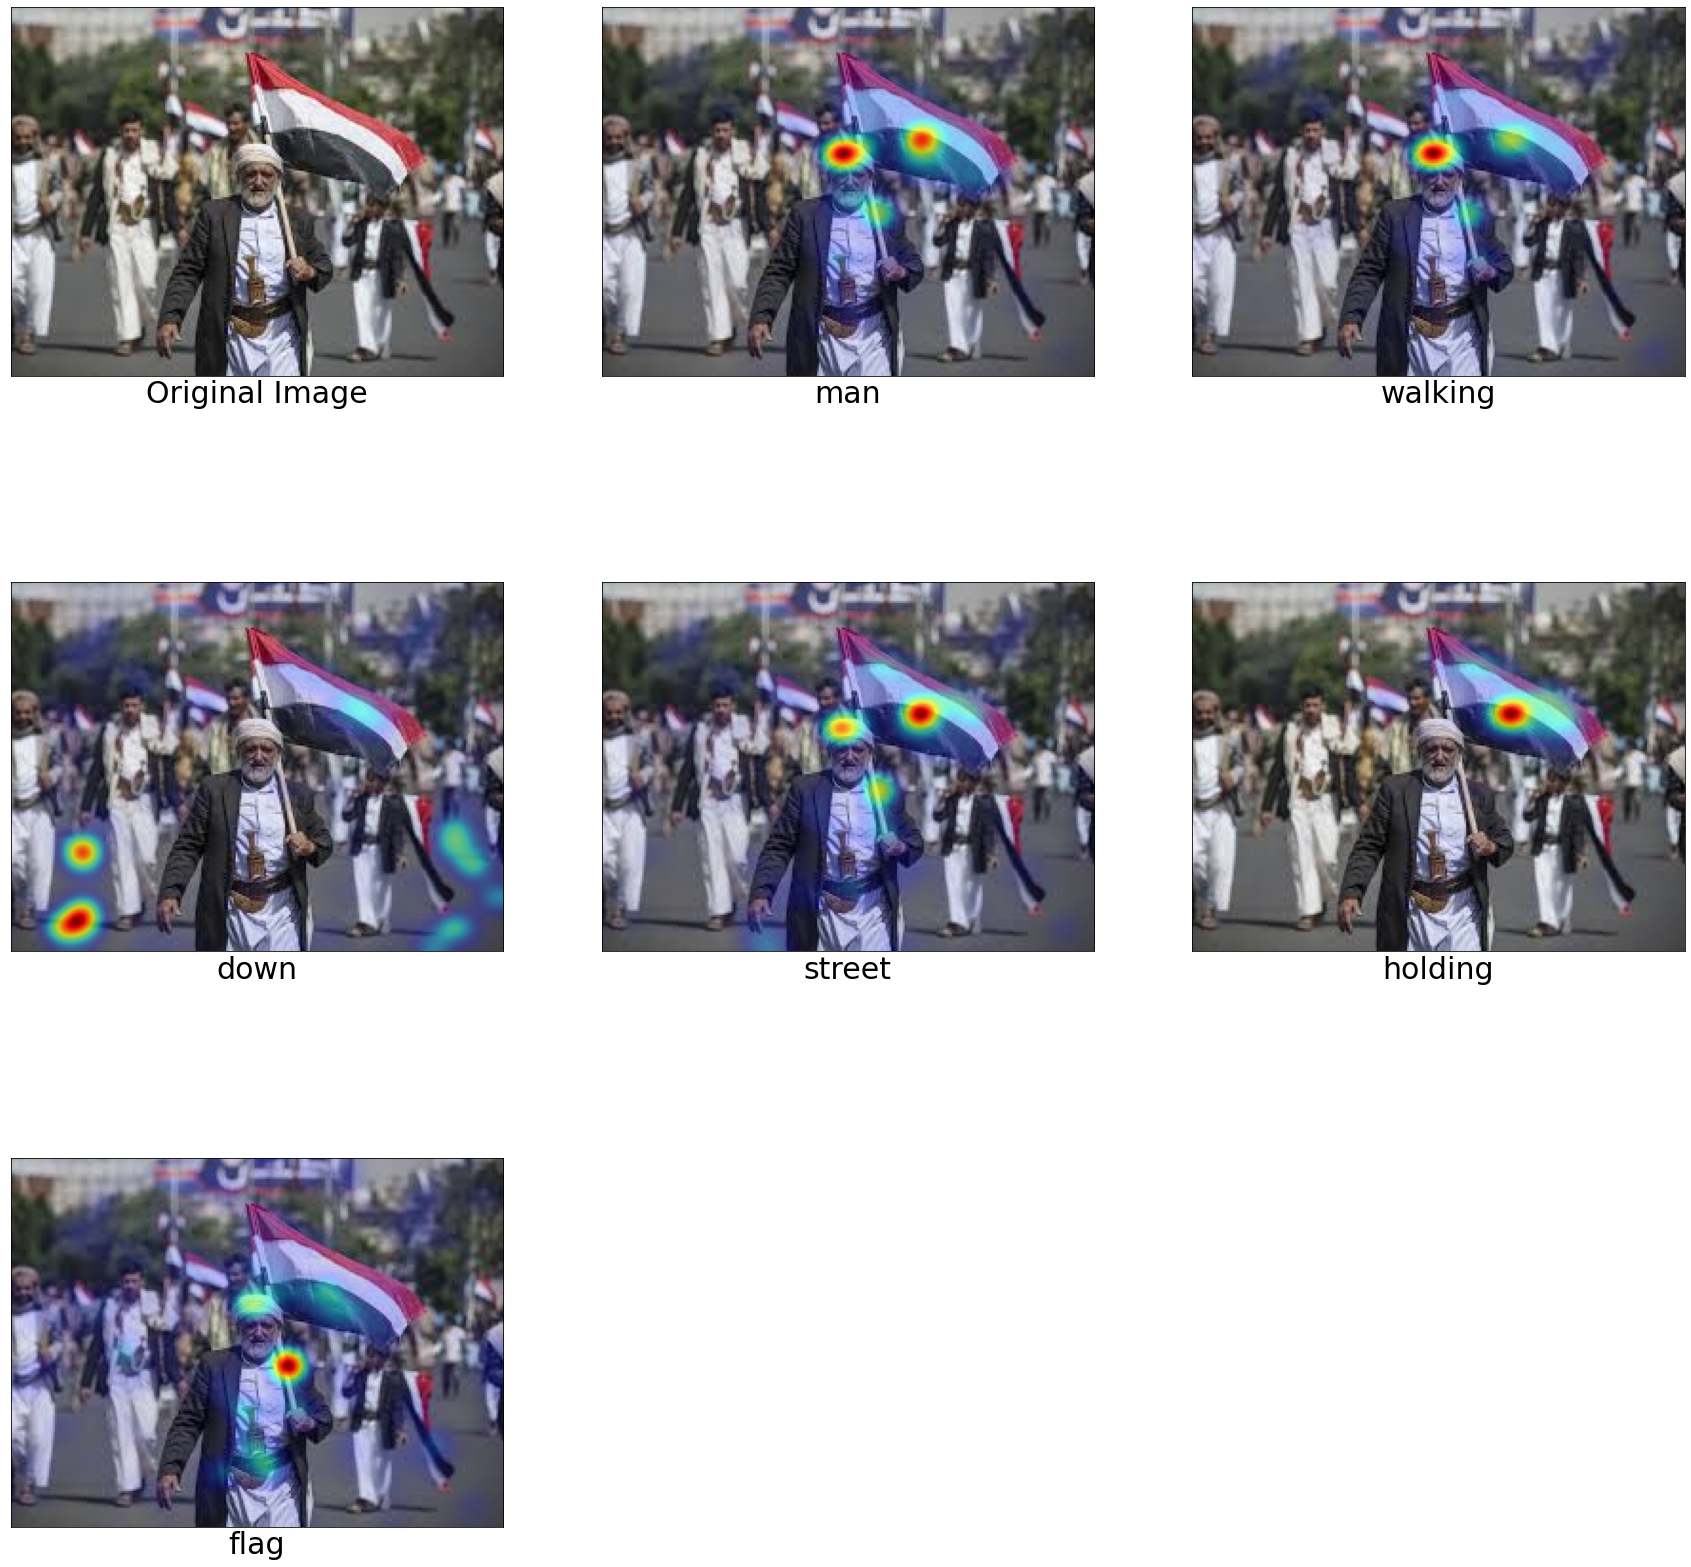

In [16]:
num_image = len(text_input.input_ids[0]) -3
# fig, ax = plt.subplots(num_image, 1, figsize=(15,5*num_image))
fig=plt.figure(figsize=(30,30))
rgb_image = cv2.imread(image_path)[:, :, ::-1]

rgb_image = np.float32(rgb_image) / 255
ax=fig.add_subplot(len(text_input.input_ids[0])//3,3,1)
ax.imshow(rgb_image)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("Original Image")
ax.xaxis.label.set_fontsize(30)

            
for i,token_id in enumerate(tqdm(text_input.input_ids[0][4:-1])):
    word = captioner.tokenizer.decode([token_id])
    gradcam_image = getAttMap(rgb_image, gradcam[i+4])
    ax=fig.add_subplot(len(text_input.input_ids[0])//3,3,i+2)
    ax.imshow(gradcam_image)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_xlabel(word)
    ax.xaxis.label.set_color('black')
    ax.xaxis.label.set_fontsize(30)

